In [1]:
import random
import os
import urllib3
import pandas as pd
from pandas import Series
import geopandas as gpd
from geopy import distance
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imageio
from matplotlib.lines import Line2D
import math

COMMON_DIR = os.path.join(os.pardir, 'common')
sys.path.insert(1, COMMON_DIR)

import data_retreiver
import time_adjusted_price as money
print(dir(data_retreiver))
from datetime import date

['DATASETS', 'DATA_PATH', 'FAMILY_DATASETS', 'GEO_DATA', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'download_datasets', 'download_family_datasets', 'download_file', 'download_geo_data', 'gpd', 'load_csv_datasets', 'load_geo_datasets', 'os', 'pd', 'urllib3']


In [2]:
data_retreiver.download_family_datasets()
data_retreiver.download_geo_data()
print()

<AxesSubplot:>

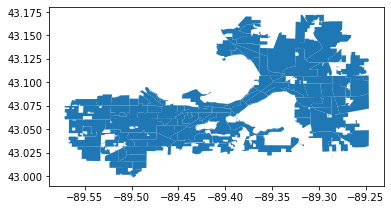

In [3]:
fam_core = data_retreiver.load_csv_datasets("single_family_core")[0]
assessment_areas = data_retreiver.load_geo_datasets("single_family_areas_shapes")[0]
assessment_areas.plot()


In [4]:
assessment_areas

OBJECTID  Area_Numbe  ORIG_FID    SHAPESTAre    SHAPESTLen  \
0           1         102       2.0  2.930758e+04    757.599384   
1           2         102       2.0  2.675664e+04    712.621722   
2           4         122       2.0  7.214181e+06  13587.720415   
3           5          31       4.0  1.167597e+07  16518.832670   
4           6          33       5.0  2.079719e+07  22832.099748   
..        ...         ...       ...           ...           ...   
134       556         102       2.0  3.233967e+07  38318.458951   
135       557         121       2.0  3.101062e+06   7728.759792   
136       558         120       2.0  1.686569e+06   5617.094536   
137       561         123      92.0  8.655775e+06  16266.033335   
138       967         125       NaN  5.851155e+06  10397.996736   

                                              geometry  
0    POLYGON ((-89.28556 43.02021, -89.28612 43.020...  
1    POLYGON ((-89.28559 43.02112, -89.28614 43.021...  
2    POLYGON ((-89.27876 43.03727, -89.27683 43.037...  
3    POLYGON ((-89.30903 43.05497, -89.30905 43.055...  
4    POLYGON ((-89.31112 43.07350, -89.31113 43.073...  
..                                                 ...  
134  POLYGON ((-89.28347 43.04631, -89.28146 43.045...  
135  POLYGON ((-89.28608 43.03148, -89.28608 43.031...  
136  POLYGON ((-89.28909 43.03144, -89.29048 43.035...  
137  POLYGON ((-89.38112 43.05242, -89.38123 43.052...  
138  POLYGON ((-89.54253 43.04581, -89.54732 43.045...  

[139 rows x 6 columns]

In [5]:
fam_core.columns

Index(['XRefParcel', 'Address', 'PropertyClass', 'PropertyUse',
       'AssessmentArea', 'MoreThanOneBuild', 'HomeStyle', 'YearBuilt',
       'Bedrooms', 'FullBaths', 'HalfBaths', 'TotalLivingArea', 'FirstFloor',
       'SecondFloor', 'ThirdFloor', 'AboveThirdFloor', 'FinishedAttic',
       'Basement', 'FinishedBasement', 'ExteriorWall1', 'ExteriorWall2',
       'Fireplaces', 'CentralAir', 'LotSize', 'Zoning1', 'Zoning2', 'Zoning3',
       'Zoning4', 'FrontageStreet', 'WaterFrontage', 'TIFDistrict',
       'TaxSchoolDist', 'AttendanceSchool', 'ElementarySchool', 'MiddleSchool',
       'HighSchool', 'RefuseDistrict', 'AlderDistrict', 'ExemptionType',
       'FireDistrict', 'FloodPlain', 'FuelStorageProximity', 'HeatingDistrict',
       'LandfillProximity', 'Landmark', 'LandscapeBuffer',
       'LocalHistoricalDist', 'LotDepth', 'LotNumber', 'LotType1', 'LotType2',
       'LotWidth', 'NationalHistoricalDist', 'NoiseAirport', 'NoiseRailroad',
       'NoiseStreet', 'OwnerChangeDate', 'Owne

In [6]:
print()

In [7]:
all_areas = set(assessment_areas['Area_Numbe'].values)

In [32]:
def weighted_std(values, weights):
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return math.sqrt(variance)

def classify_home_sqrft_year(home):
    result = ""
    sqrft = home["TotalLivingArea"]
    year = home["MaxConstructionYear"]
    if(sqrft < 1221):
        result += "small_"
    elif(sqrft < 1656):
        result += "med_"
    else:
        result += "large_"
    
    if(year < 1955):
        result += "old"
    elif(year < 1979):
        result += "aged"
    else:
        result += "newer"

    return result


def classify_homes(homes, classify_func):
    homes_copy = homes.copy()
    result = {}
    if(len(homes) < 1):
        return result

    homes_copy["temp_class"] = homes_copy.apply(lambda row: classify_func(row), axis=1)
    all_classes = set(homes_copy["temp_class"].values)
    for temp_class in all_classes:
        result[temp_class] = homes_copy[homes_copy["temp_class"] == temp_class]
    
    return result

def stddev_time_adjusted_sales_prices(data):
    sales_prices = data["Recent_Sales_Price_Inflated"].dropna().values
    sales_prices = [p for p in sales_prices if p > 0]
    return np.std(sales_prices)

def stddev_time_adjusted_sales_prices_centered(data):
    target_mean = 300000
    sales_prices = data["Recent_Sales_Price_Inflated"].dropna().values
    sales_prices = np.array([p for p in sales_prices if p > 0])
    if(len(sales_prices) > 0):
        actual_mean = np.mean(sales_prices)
        factor_to_reach_target_mean = target_mean / actual_mean
        sales_prices_target_mean = sales_prices * factor_to_reach_target_mean
        return np.std(sales_prices_target_mean) 
    return np.std(sales_prices)


def avg_time_adjusted_sales_prices(data):
    sales_prices = data["Recent_Sales_Price_Inflated"].dropna().values
    sales_prices = [p for p in sales_prices if p > 0]
    return np.mean(sales_prices)

def stddev_growth_rate(data):
    growth_rates = data["Recent_Sales_Price_Growth"].dropna().values
    result = np.std(growth_rates) 
    return result

def stddev_growth_rate_centered(data):
    target_mean = 1000
    growth_rates = data["Recent_Sales_Price_Growth"].dropna().values
    if(len(growth_rates) > 0):
        actual_mean = np.mean(growth_rates)
        factor_to_reach_target_mean = target_mean / actual_mean
        growth_rates_target_mean = growth_rates * factor_to_reach_target_mean
        return np.std(growth_rates_target_mean) 
    return np.std(growth_rates)


def avg_growth_rate(data):
    growth_rates = data["Recent_Sales_Price_Growth"].dropna().values
    return np.mean(growth_rates)

#'TotalPop', 'Men','Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'IncomePerCap', 'Poverty'
def avg_pop(data):
    populations = data["TotalPop"].dropna().values
    return np.mean(populations)

def avg_men_proportion(data):
    pop_men_women = data[["TotalPop", "Men","Women"]].dropna()
    total_pop = sum(pop_men_women["TotalPop"].values)
    total_men = sum(pop_men_women["Men"].values)
    if(total_pop == 0):
        return 0
    return total_men / total_pop

def avg_women_proportion(data):
    pop_men_women = data[['TotalPop', 'Men','Women']].dropna()
    total_pop = sum(pop_men_women['TotalPop'].values)
    if(total_pop == 0):
        return 0
    total_women = sum(pop_men_women['Women'].values)
    return total_women / total_pop

def avg_hispanic(data):
    percents = data["Hispanic"].dropna().values
    return np.mean(percents)
    
def avg_white(data):
    percents = data["White"].dropna().values
    return np.mean(percents)

def avg_black(data):
    percents = data["Black"].dropna().values
    return np.mean(percents)

def avg_asian(data):
    percents = data["Asian"].dropna().values
    return np.mean(percents)

def avg_income_per_capita(data):
    per_capita_incomes = data["IncomePerCap"].dropna().values
    return np.mean(per_capita_incomes)

def avg_poverty_percent(data):
    percents = data["Poverty"].dropna().values
    return np.mean(percents)

def num_homes(data):
    return len(data)

def homes_in_area(data, area):
    return data[data["AssessmentArea"] == area]

def calculate_area_summaries(all_areas, data, summary_fn):
    result = {} #Dictionary area --> summary statistic calualted with summary_fn
    for area in all_areas:
        area_homes = homes_in_area(data, area)
        if(len(area_homes) < 1):
            result[area] = np.nan
        summary = summary_fn(area_homes)
        result[area] = summary
    return result


def calculate_area_summaries_grouped(all_areas, data, classify_func, summary_func, weighted_avg=True):
    result = {} #Dictionary area --> summary statistic calualted with summary_fn
    for area in all_areas:
        area_homes = homes_in_area(data, area)
        if(len(area_homes) < 1):
            result[area] = np.nan
        
        home_groups = classify_homes(area_homes, classify_func)
        summary = summary_by_group(home_groups, summary_func, weighted_avg)
        if(summary == np.nan):
            print("NAN")
        result[area] = summary
    return result


def summary_by_group(home_groups, summary_func, weighted_avg=True):
    #home_classifications is a dictionary 
    #   some custom class -> df of homes meeting that class.abs
    all_groups = set(home_groups.keys())

    #dict some custom class -> (summary_stat, count)
    summaries = {}

    total_count = 0
    result_weighted = 0
    result_unweighted = 0

    for c in all_groups:
        homes_of_group = home_groups[c]
        n = len(homes_of_group)
        summary_stat = summary_func(homes_of_group)

        if(not math.isnan(summary_stat)):
            summaries[c] = (summary_stat, n)
            total_count += n
        
    if(total_count < 1):
        return np.nan

    if(weighted_avg):
        for c, (stat, n) in summaries.items():
            proportion = n / total_count
            result_weighted += proportion * stat
        return result_weighted
    else:
        return np.mean([stat for (stat, n) in summaries.values()])




def add_col_from_area_dict(geo_df, col_name, dict):
    geo_df[col_name] = geo_df["Area_Numbe"].apply(lambda area: dict[area])
    return geo_df

area_num_homes = calculate_area_summaries(all_areas, fam_core, num_homes)
area_avg_growth_rate = calculate_area_summaries_grouped(all_areas, fam_core, classify_home_sqrft_year, avg_growth_rate)
area_stddev_growth_rate = calculate_area_summaries_grouped(all_areas, fam_core, classify_home_sqrft_year, stddev_growth_rate)
area_avg_sales_prices = calculate_area_summaries_grouped(all_areas, fam_core, classify_home_sqrft_year, avg_time_adjusted_sales_prices)
area_stddev_sales_prices = calculate_area_summaries_grouped(all_areas, fam_core, classify_home_sqrft_year, stddev_time_adjusted_sales_prices_centered)


assmt_areas = add_col_from_area_dict(assessment_areas, "Num_Homes", area_num_homes)
assmt_areas = add_col_from_area_dict(assmt_areas, "Growth_Std", area_stddev_growth_rate)
assmt_areas = add_col_from_area_dict(assmt_areas, "Growth_Mean", area_avg_growth_rate)
assmt_areas = add_col_from_area_dict(assmt_areas, "Sales_Price_Std", area_stddev_sales_prices)
assmt_areas = add_col_from_area_dict(assmt_areas, "Sales_Price_Mean", area_avg_sales_prices)




In [33]:
area_pop = calculate_area_summaries(all_areas, fam_core, avg_pop)
area_men = calculate_area_summaries(all_areas, fam_core, avg_men_proportion)
area_women = calculate_area_summaries(all_areas, fam_core, avg_women_proportion)

area_avg_hispanic = calculate_area_summaries(all_areas, fam_core, avg_hispanic)
area_avg_white = calculate_area_summaries(all_areas, fam_core, avg_white)
area_avg_black = calculate_area_summaries(all_areas, fam_core, avg_black)
area_avg_asian = calculate_area_summaries(all_areas, fam_core, avg_asian)
area_avg_income_per_capita = calculate_area_summaries(all_areas, fam_core, avg_income_per_capita)
area_avg_poverty_percent = calculate_area_summaries(all_areas, fam_core, avg_poverty_percent)



assmt_areas = add_col_from_area_dict(assmt_areas, "Population", area_pop)
assmt_areas = add_col_from_area_dict(assmt_areas, "Male_Proportion", area_men)
assmt_areas = add_col_from_area_dict(assmt_areas, "Female_Proportion", area_women)
assmt_areas = add_col_from_area_dict(assmt_areas, "Hispanic_Percentage", area_avg_hispanic)
assmt_areas = add_col_from_area_dict(assmt_areas, "White_Percentage", area_avg_white)
assmt_areas = add_col_from_area_dict(assmt_areas, "Black_Percentage", area_avg_black)
assmt_areas = add_col_from_area_dict(assmt_areas, "Asian_Percentage", area_avg_asian)
assmt_areas = add_col_from_area_dict(assmt_areas, "Income_Per_Capita", area_avg_income_per_capita)
assmt_areas = add_col_from_area_dict(assmt_areas, "Poverty_Percentage", area_avg_poverty_percent)

assmt_areas

OBJECTID  Area_Numbe  ORIG_FID    SHAPESTAre    SHAPESTLen  \
0           1         102       2.0  2.930758e+04    757.599384   
1           2         102       2.0  2.675664e+04    712.621722   
2           4         122       2.0  7.214181e+06  13587.720415   
3           5          31       4.0  1.167597e+07  16518.832670   
4           6          33       5.0  2.079719e+07  22832.099748   
..        ...         ...       ...           ...           ...   
134       556         102       2.0  3.233967e+07  38318.458951   
135       557         121       2.0  3.101062e+06   7728.759792   
136       558         120       2.0  1.686569e+06   5617.094536   
137       561         123      92.0  8.655775e+06  16266.033335   
138       967         125       NaN  5.851155e+06  10397.996736   

                                              geometry  Num_Homes  \
0    POLYGON ((-89.28556 43.02021, -89.28612 43.020...        323   
1    POLYGON ((-89.28559 43.02112, -89.28614 43.021...        323   
2    POLYGON ((-89.27876 43.03727, -89.27683 43.037...        304   
3    POLYGON ((-89.30903 43.05497, -89.30905 43.055...        462   
4    POLYGON ((-89.31112 43.07350, -89.31113 43.073...        566   
..                                                 ...        ...   
134  POLYGON ((-89.28347 43.04631, -89.28146 43.045...        323   
135  POLYGON ((-89.28608 43.03148, -89.28608 43.031...         71   
136  POLYGON ((-89.28909 43.03144, -89.29048 43.035...         89   
137  POLYGON ((-89.38112 43.05242, -89.38123 43.052...        199   
138  POLYGON ((-89.54253 43.04581, -89.54732 43.045...         23   

       Growth_Std  Growth_Mean  Sales_Price_Std  Sales_Price_Mean  \
0     7949.015486  2736.883347     47082.532141     250924.020635   
1     7949.015486  2736.883347     47082.532141     250924.020635   
2             NaN          NaN     43360.625648     328108.081349   
3     4028.798217  -158.141803     79139.813449     201066.369550   
4     4415.112869  -961.066618     80354.654981     189102.912359   
..            ...          ...              ...               ...   
134   7949.015486  2736.883347     47082.532141     250924.020635   
135  10274.027840 -9064.812445     67613.292220     260850.204225   
136   3338.510367 -2961.311382     29343.708205     260983.191011   
137   4805.090452  -863.655581    108611.244865     129735.012657   
138           NaN          NaN     19721.191507     332605.748188   

     Black_Percentage   Population  Male_Proportion  Female_Proportion  \
0            5.100000  3276.000000         0.503663           0.496337   
1            5.100000  3276.000000         0.503663           0.496337   
2            5.100000  3276.000000         0.503663           0.496337   
3            6.100000  3246.000000         0.511091           0.488909   
4            4.427915  2555.300353         0.507041           0.492959   
..                ...          ...              ...                ...   
134          5.100000  3276.000000         0.503663           0.496337   
135          5.100000  3276.000000         0.503663           0.496337   
136          5.100000  3276.000000         0.503663           0.496337   
137         17.300000  6935.000000         0.593944           0.406056   
138          2.521739  3273.673913         0.491025           0.508975   

     Hispanic_Percentage  White_Percentage  Asian_Percentage  \
0               1.500000         80.800000          5.700000   
1               1.500000         80.800000          5.700000   
2               1.500000         80.800000          5.700000   
3               6.100000         80.800000          5.200000   
4               4.042049         88.131449          2.177385   
..                   ...               ...               ...   
134             1.500000         80.800000          5.700000   
135             1.500000         80.800000          5.700000   
136             1.500000         80.800000          5.700000   
137          

In [38]:
assmt_areas_data = assmt_areas.drop(columns=["OBJECTID", "SHAPESTAre", "SHAPESTLen", "ORIG_FID", "geometry"])
assmt_areas_data = assmt_areas_data.set_index("Area_Numbe")
assmt_areas_data.to_csv("single_family_areas_info.csv")

In [14]:
def truncate_value(val, min, max):
    if(val < min):
        return min
    if(val > max):
        return max
    return val

def setup_map_axes():
    fig1, ax1 = plt.subplots()
    ax1.set_axis_off()
    ax1.set_xlim(-89.57, -89.245)
    ax1.set_ylim(43.00, 43.17)
    ax1.margins(0.0)
    #fig1.tight_layout()
    return (fig1, ax1)


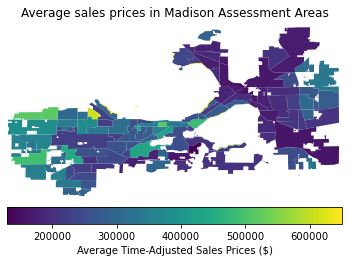

In [13]:
## Sales Price_Mean
legend_options={'label': "Average Time-Adjusted Sales Prices ($)",
             'orientation': "horizontal", 'pad': 0.05}

assmt_areas_temp = assmt_areas.copy()
assmt_areas_temp["Sales_Price_Mean"] = assmt_areas_temp["Sales_Price_Mean"].apply(lambda x: truncate_value(x, 0, 650000))

fig, ax = setup_map_axes()
ax.set_title("Average sales prices in Madison Assessment Areas")
assmt_areas_temp.plot(ax=ax, column="Sales_Price_Mean", legend=True, legend_kwds=legend_options)
fig.savefig("price_avg_assmt.svg")
fig.savefig("price_avg_assmt.png", dpi=300)

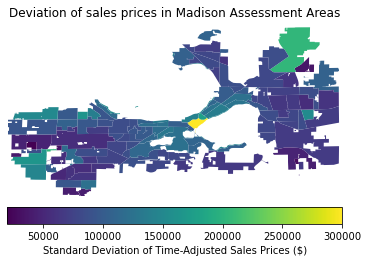

In [122]:
## Sales Price STD Dev
legend_options={'label': "Standard Deviation of Time-Adjusted Sales Prices ($)",
             'orientation': "horizontal", 'pad': 0.05}

assmt_areas_temp = assmt_areas.copy()
assmt_areas_temp["Sales_Price_Std"] = assmt_areas_temp["Sales_Price_Std"].apply(lambda x: truncate_value(x, 0, 0.3e6))

fig, ax = setup_map_axes()
ax.set_title("Deviation of sales prices in Madison Assessment Areas")
assmt_areas_temp.plot(ax=ax, column="Sales_Price_Std", legend=True, legend_kwds=legend_options)
fig.savefig("price_dev_assmt.svg")
fig.savefig("price_dev_assmt.png", dpi=300)

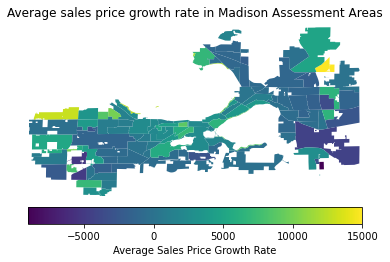

In [123]:
## Growth Rate Mean
legend_options={'label': "Average Sales Price Growth Rate",
             'orientation': "horizontal", 'pad': 0.05}

assmt_areas_temp = assmt_areas.copy()
assmt_areas_temp["Growth_Mean"] = assmt_areas_temp["Growth_Mean"].apply(lambda x: truncate_value(x, -11000, 15000))

fig, ax = setup_map_axes()
ax.set_title("Average sales price growth rate in Madison Assessment Areas")
assmt_areas_temp.plot(ax=ax, column="Growth_Mean", legend=True, legend_kwds=legend_options)
fig.savefig("growth_avg_assmt.svg")
fig.savefig("growth_avg_assmt.png", dpi=300)

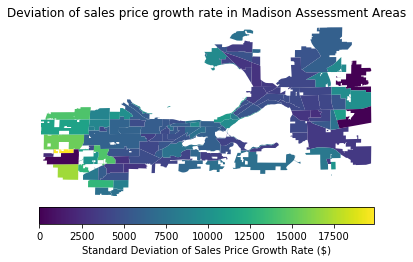

In [124]:
## Growth Rate Standard Deviation
legend_options={'label': "Standard Deviation of Sales Price Growth Rate ($)",
             'orientation': "horizontal", 'pad': 0.05}

assmt_areas_temp = assmt_areas.copy()
assmt_areas_temp["Growth_Std"] = assmt_areas_temp["Growth_Std"].apply(lambda x: truncate_value(x, 0, 50000))

fig, ax = setup_map_axes()
ax.set_title("Deviation of sales price growth rate in Madison Assessment Areas")
assmt_areas_temp.plot(ax=ax, column="Growth_Std", legend=True, legend_kwds=legend_options)
fig.savefig("price_dev_assmt.svg")
fig.savefig("growth_dev_assmt.png", dpi=300)

<AxesSubplot:>

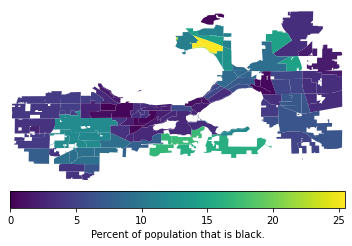

In [18]:
## Black Percentage
legend_options={'label': "Percent of population that is black.",
             'orientation': "horizontal", 'pad': 0.05}

assmt_areas_temp = assmt_areas.copy()
#assmt_areas_temp["Black_Percentage"] = assmt_areas_temp["Black_Percentage"].apply(lambda x: truncate_value(x, 0, 50000))

fig, ax = setup_map_axes()
ax.set_title("")
assmt_areas_temp.plot(ax=ax, column="Black_Percentage", legend=True, legend_kwds=legend_options)
#fig.savefig("price_dev_assmt.svg")
#fig.savefig("growth_dev_assmt.png", dpi=300)

In [11]:
raw = pd.read_csv("raw.csv")
print()

In [12]:
raw = raw[raw["PropertyUse"] == "Single family"]
raw

OBJECTID       Parcel   XRefParcel              Address  \
0             1  71010118159  71010118159   549 Shady Wood Way   
1             2  71010201029  71010201029    4937 Goldfinch Dr   
2             3  71010203067  71010203067   501 Hummingbird Ln   
3             4  71010204023  71010204023     409 Acewood Blvd   
4             5  71010204122  71010204122   510 Hummingbird Ln   
...         ...          ...          ...                  ...   
80247     80248  81019309047  81019309047         14 Buhler Ct   
80248     80249  81021109089  81021109089  4138 Westerfield Ln   
80249     80250  81021109170  81021109170  4102 Westerfield Ln   
80250     80251  81021302245  81021302245     3113 Old Gate Rd   
80251     80252  81021303384  81021303384      3106 Portage Rd   

            DateParcelChanged PropertyClass    PropertyUse  AssessmentArea  \
0      2020/06/03 00:00:00+00   Residential  Single family              47   
1      2020/06/03 00:00:00+00   Residential  Single family              43   
2      2020/06/03 00:00:00+00   Residential  Single family              43   
3      2020/06/03 00:00:00+00   Residential  Single family              43   
4      2020/06/03 00:00:00+00   Residential  Single family              43   
...                       ...           ...            ...             ...   
80247  2020/06/03 00:00:00+00   Residential  Single family              72   
80248  2020/06/03 00:00:00+00   Residential  Single family              76   
80249  2020/06/03 00:00:00+00   Residential  Single family              76   
80250  2020/06/03 00:00:00+00   Residential  Single family              76   
80251  2020/06/03 00:00:00+00   Residential  Single family              76   

               AreaName MoreThanOneBuild  ... StreetID  StormOutfall  \
0      Heritage Heights              NaN  ...     7872      ST18B396   
1       Rolling Meadows              NaN  ...     3360      ST18A395   
2       Rolling Meadows              NaN  ...     4106      ST18A395   
3       Rolling Meadows              NaN  ...       24      ST18A395   
4       Rolling Meadows              NaN  ...     4106      ST18A395   
...                 ...              ...  ...      ...           ...   
80247   Whitetail Ridge              NaN  ...     1181           NaN   
80248     Holiday Bluff              NaN  ...     9315      ST04B385   
80249     Holiday Bluff              NaN  ...     9315      ST04B385   
80250     Holiday Bluff              NaN  ...     6293      ST04U999   
80251     Holiday Bluff              NaN  ...     6766      ST04U999   

       FireDemandZone  FireDemandSubZone      PropertyChangeDate  \
0                   0                  0  1970/01/01 00:00:00+00   
1                   0                  0  1970/01/01 00:00:00+00   
2                   0                  0  1995/06/06 00:00:00+00   
3                   0                  0  1995/11/01 00:00:00+00   
4                   0                  0  1995/06/07 00:00:00+00   
...               ...                ...                     ...   
80247               0                  0  1970/01/01 00:00:00+00   
80248               0                  0  1970/01/01 00:00:00+00   
80249               0                  0  1970/01/01 00:00:00+00   
80250               0                  0  1970/01/01 00:00:00+00   
80251               0                  0  1970/01/01 00:00:00+00   

       MaxConstructionYear         XCoord         YCoord   SHAPESTArea  \
0                     1973  844829.292139  488257.095163  11700.076050   
1                     1965  844117.989715  488913.420354  10801.439362   
2                     1965  843486.093675  488653.502828  10736.872589   
3                     1962  843160.829281  488878.167502  11654.967041   
4                     1964  843301.227031  488472.810682  11990.388947   
...                    ...            ...            ...           ...   
80247                 1994  828763.001815  506848.194827  17867.567963   
802

In [16]:
#set(raw["CensusTract"].values)
list(raw.columns)

['OBJECTID',
 'Parcel',
 'XRefParcel',
 'Address',
 'DateParcelChanged',
 'PropertyClass',
 'PropertyUse',
 'AssessmentArea',
 'AreaName',
 'MoreThanOneBuild',
 'HomeStyle',
 'YearBuilt',
 'Bedrooms',
 'FullBaths',
 'HalfBaths',
 'TotalLivingArea',
 'FirstFloor',
 'SecondFloor',
 'ThirdFloor',
 'AboveThirdFloor',
 'FinishedAttic',
 'Basement',
 'FinishedBasement',
 'ExteriorWall1',
 'ExteriorWall2',
 'Fireplaces',
 'CentralAir',
 'PartialAssessed',
 'AssessedByState',
 'CurrentLand',
 'CurrentImpr',
 'CurrentTotal',
 'PreviousLand',
 'PreviousImpr',
 'PreviousTotal',
 'NetTaxes',
 'SpecialAssmnt',
 'OtherCharges',
 'TotalTaxes',
 'LotSize',
 'Zoning1',
 'Zoning2',
 'Zoning3',
 'Zoning4',
 'FrontageStreet',
 'WaterFrontage',
 'TIFDistrict',
 'TaxSchoolDist',
 'AttendanceSchool',
 'ElementarySchool',
 'MiddleSchool',
 'HighSchool',
 'Ward',
 'StateAssemblyDistrict',
 'RefuseDistrict',
 'RefuseURL',
 'PreviousLand2',
 'PreviousImpr2',
 'PreviousTotal2',
 'AlderDistrict',
 'AssessmentChang